<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/SP/Camera_measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6> Wavelengths measurements with digital camera</font>

Evgeny Kolonsky, 2025

v.0.3.1

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from scipy.optimize import fsolve
from math import degrees as deg

# Model

Theoretical expression for light diffraction when incident light assumed to be perpendicutalr to lattice is
$$
n \lambda = d \sin \beta_n,
\tag{1}
$$
where $\lambda$ - light wave length, $d$ - diffraction grating parameter, $n$ - order number, $\beta_n$ - deviation angle of order $n$ light beam.

When incident light falls under an arbitrary angle $\alpha_0$ to lattice plane perpendicular, the expression is written in form
$$ 2 d \sin\frac{\beta_n}{2} \cos\left(\alpha_0 +\frac{\beta_n}{2}\right)
= n \lambda
, \quad n =  \pm 1, \pm 2, ..
\tag{2}
$$
Here $\beta_n$ is the angle between incident light beam and  deviated beam of order $n$, which we can measure rather accurately in optical spectroscopy experiment.

For $\alpha_0=0$ (light falls ⟂) we receive eq.(1).

Otherwise we expect to see non-symmetry in deviation angles $\beta_{\pm n}$ .

## Lattice angle position


We can neither ensure $\alpha_0=0$ nor accurately measure $\alpha_0$ directly due to construction of the experiment set.

The unknown angle $\alpha_0$ between lattice plane perpendicular and light beam can be found indirectly by measuring $\beta_{\pm 1}$, even when lattice period $d$ and wavelength $\lambda$ are also unknown. For a pair $\pm n$ using eq.(2) we have  
$$
\sin \frac{\beta_{+n}}{2} \cos\left( \alpha_0 + \frac{\beta_{+n}}{2}\right) + \sin \frac{\beta_{-n}}{2} \cos\left( \alpha_0 + \frac{\beta_{-n}}{2}\right) =0.   
$$
We have one equation with one unknown parameter $\alpha_0$. It can be easiliy solved analytically. Denoting for first series $n=\pm1$
$$
c_{1} = \cos\frac{\beta_{+1}}{2}, \quad s_{1} = \sin\frac{\beta_{+1}}{2}, \\
c_{2} = \cos\frac{\beta_{-1}}{2}, \quad s_{2} = \sin\frac{\beta_{-1}}{2}, \\
C = c_{1} s_{1} + c_{2} s_{2}, \quad
D = s_{1}^2 + s_{2}^2
$$
we found
$$
\alpha_0 = \arccos\frac{D}{\sqrt{C^2+D^2}}.
$$
Since we measure $\beta_n$ rather accurately, accuracy of $\alpha_0$ is also reasonably high. Uncertainty of $\alpha_0$ can be decreased further by averaging $\alpha_0$ for all known pairs.  

In [14]:
def get_alpha0(beta_plus, beta_minus):
  c1 = np.cos(beta_plus/2)
  s1 = np.sin(beta_plus/2)
  c2 = np.cos(beta_minus/2)
  s2 = np.sin(beta_minus/2)
  D = s1*s1 + s2*s2
  C = c1*s1 + c2*s2
  acos =  D / np.sqrt(C*C + D*D)
  alpha0_arr = np.arccos(acos)
  alpha0 = np.mean(alpha0_arr)
  alpha0_err = np.std(alpha0_arr) / np.sqrt(len(alpha0_arr) - 1)
  return alpha0, alpha0_err

def get_pairs(beta, colors, orders):
  def get_pair(color_ind, order):
    beta_plus = beta[(color_index == color_ind) & (n == order)]
    beta_minus = beta[(color_index == color_ind) & (n == -order)]
    if len(beta_plus) == 1 and len(beta_minus) == 1:
      return (beta_plus[0], beta_minus[0])
    else:
      return None
  betas = [get_pair(color_ind, order) for color_ind in np.unique(colors) for order in np.unique(orders)]
  beta_plus = np.array([b[0] for b in betas if b is not None])
  beta_minus = np.array([b[1] for b in betas if b is not None])
  return beta_plus, beta_minus

# Measurements

## Mercury

Measuring lattice parameter $d$ with Mercury lamp

Measured with spectrograph

![H](https://github.com/tphlabs/data/blob/main/Lab4_SP/mercury.png?raw=true')

In [43]:
# lattice parameter estimation with Merucry green line

measurements = '''
# color_index beta(degrees) order
# 1 - violet, 2 blue, 3 green, 4,5 - yellow, 6,7 - red
# order 1
1 7.065 1
2 7.56 1
3 9.495 1
4 10.035 1
5 10.035 1
# order 2
1 14.13 2
2 15.21 2
3 19.125 2
4 20.25 2
5 20.295 2
# order 3
1 21.33 3
2 23.04 3
3 29.205 3
4 31.005 3
5 31.14 3
# order 4
1 28.89 4
2 31.275 4
3 40.32 4
# order -1
1 -7.065 -1
2 -7.605 -1
3 -9.54 -1
4 -10.125 -1
5 -10.125 -1
# order -2
1 -14.265 -2
2 -15.39 -2
3 -19.486 -2
# order -3
1 -21.85 -3
2 -23.625 -3
3 -30.24 -3
4 -32.175 -3
5 -32.31 -3
# order -4
2 -32.445 -4
3 -42.57 -4
'''

color_index, beta, n = np.genfromtxt(measurements.splitlines(), unpack=True)

beta *= np.pi / 180

beta_plus, beta_minus = get_pairs(beta, color_index, n)

alpha0, alpha0_err = get_alpha0(beta_plus, beta_minus)
print(f'alpha0: {deg(alpha0):.1f} ± {deg(alpha0_err):.1f} degree')


alpha0: 2.7 ± 0.2 degree


In [44]:
beta_green = beta[color_index == 3]
n_green = n[color_index == 3]

lmbd_green = 545e-9 #m
d_arr = n_green * lmbd_green / ( 2 * np.sin(beta_green/2) * np.cos(-alpha0 + beta_green/2) )
d = np.mean(d_arr)
d_err = np.std(d_arr) / np.sqrt(len(d_arr) - 1)
print(rf'd = {d *1e6:.3f} ± {d_err*1e6:.3f} um')
print(rf'd nominal 7500/inch = {25.4e-3 / 7500 *1e6:.3f} um')


d = 3.301 ± 0.003 um
d nominal 7500/inch = 3.387 um


d = 3.301 um
Violet 404     : lambda = 404.5 ± 0.5 nm, 7 points
Blue 436       : lambda = 435.1 ± 0.3 nm, 8 points
Green 546      : lambda = 545.0 ± 0.6 nm, 8 points
yellow 577     : lambda = 576.2 ± 0.7 nm, 5 points
yellow 579     : lambda = 577.3 ± 0.6 nm, 5 points


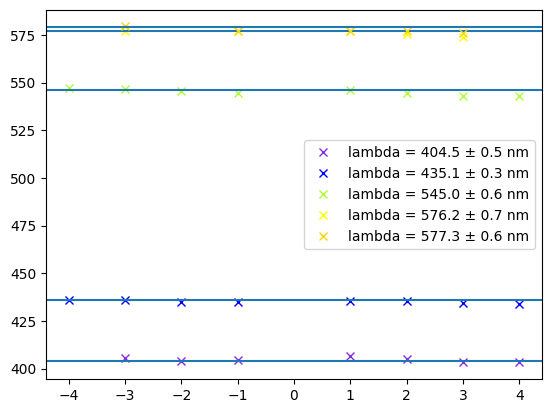

In [45]:
colors = ['Unknown', 'Violet 404', 'Blue 436', 'Green 546', 'yellow 577','yellow 579']
python_colors = ['gray',     'blueviolet', 'blue',    'greenyellow','yellow', 'gold']
nominal_waves = [np.NaN, 404, 436, 546, 577, 579]

print(rf'd = {d*1e6:.3f} um')

for ix in range(1, len(colors)):
  b = beta[color_index == ix]
  n_ix =  n[color_index == ix]
  lmbd = 2 * d *  np.sin(b / 2) * np.cos(-alpha0 + b / 2) /n_ix
  lmbd_mean = np.mean(lmbd)
  lmbd_err = np.std(lmbd) / np.sqrt(len(lmbd) - 1)
  lmbd_n = len(lmbd)
  print(rf'{colors[ix]:<15}: lambda = {lmbd_mean*1e9:.1f} ± {lmbd_err*1e9:.1f} nm, {lmbd_n:d} points' )

  plt.plot(n_ix, 2 * d *  np.sin(b / 2) * np.cos(-alpha0 + b / 2) /n_ix *1e9, 'x', color=python_colors[ix],
           label=f'lambda = {lmbd_mean*1e9:.1f} ± {lmbd_err*1e9:.1f} nm')
  plt.axhline(nominal_waves[ix])
  plt.legend()


## Hydrogen

Measured with spectrograph

![H](https://github.com/tphlabs/data/blob/main/Lab4_SP/hydrogen.png?raw=true')

d = 3.301 um
alpha0: 3.6 ± 1.3 degree
Violet 434     : lambda = 436.5 ± 3.5 nm, 6 points
Cian 486       : lambda = 489.4 ± 3.0 nm, 8 points
Red 657        : lambda = 661.8 ± 4.4 nm, 6 points


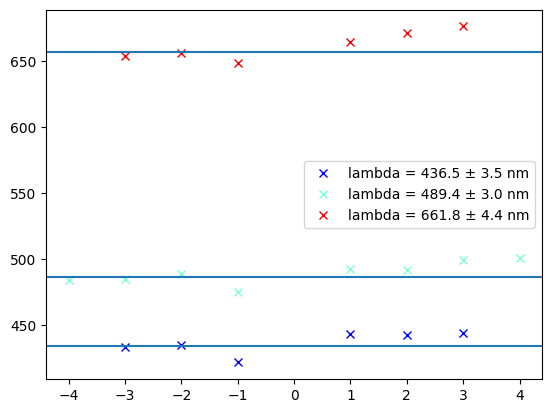

In [46]:
colors = ['Unidentified', 'Violet 434', 'Cian 486', 'Red 657']
python_colors = ['gray', 'blue', 'aquamarine', 'red']
nominal_waves = [np.NaN, 434, 486, 657]

print(rf'd = {d*1e6:.3f} um')

measurements = '''
# coor_index beta(degrees) order
# order +1, -1
1 7.695 1
1 -7.38 -1
2 8.55 1
2 -8.325 -1
3 11.565 1
3 -11.43 -1
# 0 - unidentified blueish -7.02
# order +2, -2
1 15.45 2
1 -15.435 -2
2 17.19 2
2 -17.415 -2
3 23.715 2
3 -23.805 -2
# order +3, -3
1 23.49 3
1 -23.58 -3
2 26.595 3
2 -26.64 -3
3 37.08 3
3 -37.44 -3
# order 4 - weak blue or cyan?
2 36.54 4
2 -36.855 -4
'''

color_index, beta, n = np.genfromtxt(measurements.splitlines(), unpack=True)

beta *= np.pi / 180

beta_plus, beta_minus = get_pairs(beta, color_index, n)

alpha0, alpha0_err = get_alpha0(beta_plus, beta_minus)
print(f'alpha0: {deg(alpha0):.1f} ± {deg(alpha0_err):.1f} degree')


for ix in range(1, 4):
  b = beta[color_index == ix]
  n_ix =  n[color_index == ix]
  lmbd = 2 * d *  np.sin(b / 2) * np.cos(-alpha0 + b / 2) /n_ix
  lmbd_mean = np.mean(lmbd)
  lmbd_err = np.std(lmbd) / np.sqrt(len(lmbd) - 1)
  lmbd_n = len(lmbd)
  print(rf'{colors[ix]:<15}: lambda = {lmbd_mean*1e9:.1f} ± {lmbd_err*1e9:.1f} nm, {lmbd_n:d} points' )

  plt.plot(n_ix, 2 * d *  np.sin(b / 2) * np.cos(-alpha0 + b / 2) /n_ix *1e9, 'x', color=python_colors[ix],
           label=f'lambda = {lmbd_mean*1e9:.1f} ± {lmbd_err*1e9:.1f} nm')
  plt.axhline(nominal_waves[ix])
  plt.legend()


# References

- "Physics Laboratory Manual", 3d ed., Wall , Levine and Christensen, Experiment 75 Wave Length of Light: Diffraction Grating, p.297, eq.75.2 and 75.3
